In [ ]:
!pip install opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import kagglehub
import pandas as pd
import itertools

torch.backends.cudnn.benchmark = True

In [ ]:
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

CT_ROOT = os.path.join(path, "Dataset", "Brain Tumor CT scan Images")
CT_TUMOR = os.path.join(CT_ROOT, "Tumor")
CT_HEALTHY = os.path.join(CT_ROOT, "Healthy")

print("CT dataset path:", CT_ROOT)

100%|██████████| 361M/361M [00:04<00:00, 78.9MB/s]

Extracting files...


CT dataset path: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1/Dataset/Brain Tumor CT scan Images


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

With the preprocessing process we would in the CNN model we chose these parameters:

In [ ]:
IMAGE_SIZE = 224

def preprocess_ct(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Gaussian blur
    img = cv2.GaussianBlur(img, (3,3), 0)

    # Normalize
    img = img.astype(np.float32)
    img = (img - img.mean()) / (img.std() + 1e-6)

    # 3-channel
    img = np.stack([img, img, img], axis=-1)
    return img


In [ ]:
cached_ct_images = []
cached_ct_labels = []

for label_name, folder in [("Tumor", CT_TUMOR), ("Healthy", CT_HEALTHY)]:
    label = 1 if label_name == "Tumor" else 0
    for f in os.listdir(folder):
        if f.lower().endswith(("png","jpg","jpeg")):
            img = preprocess_ct(os.path.join(folder, f))
            cached_ct_images.append(img)
            cached_ct_labels.append(label)

cached_ct_images = np.array(cached_ct_images)
cached_ct_labels = np.array(cached_ct_labels)

print("Total CT samples:", len(cached_ct_labels))

Total CT samples: 4618


In [ ]:
class CachedCTDataset(Dataset):
    def __init__(self, indices, train=True):
        self.indices = indices
        self.train = train
        self.aug = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
        self.noaug = transforms.ToTensor()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        img = cached_ct_images[idx]
        label = cached_ct_labels[idx]

        img = (255*(img - img.min())/(img.max()-img.min())).astype("uint8")
        img = Image.fromarray(img)

        img = self.aug(img) if self.train else self.noaug(img)
        return img, label

In [ ]:
def build_model():
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)

    if torch.__version__.startswith("2"):
        model = torch.compile(model)

    return model

In [ ]:
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler("cuda")

In [ ]:
def train_one_epoch(model, optimizer, loader):
    model.train()
    running_loss = 0
    total, correct = 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += len(labels)

    return running_loss / len(loader), correct / total

In [ ]:
def eval_epoch(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(imgs)

            preds = outputs.argmax(1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += len(labels)

    return correct / total, preds_all, labels_all

In [ ]:
param_grid = {
    "lr": [1e-4, 3e-4, 1e-5],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"],
    "weight_decay": [0, 1e-4]
}

In [ ]:
def make_optimizer(model, name, lr, wd):
    if name == "adam":
        return optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

In [ ]:
def evaluate_config(lr, bs, opt_name, wd):
    label_array = cached_ct_labels

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_accs, fold_f1s = [], []

    for fold, (train_idx, val_idx) in enumerate(
        skf.split(np.zeros(len(label_array)), label_array), 1
    ):
        train_loader = DataLoader(CachedCTDataset(train_idx, train=True), batch_size=bs, shuffle=True, num_workers=2)
        val_loader   = DataLoader(CachedCTDataset(val_idx, train=False), batch_size=bs, shuffle=False, num_workers=2)

        model = build_model()
        optimizer = make_optimizer(model, opt_name, lr, wd)

        # Train
        for epoch in range(2):
            train_one_epoch(model, optimizer, train_loader)

        acc, preds_all, labels_all = eval_epoch(model, val_loader)
        f1 = f1_score(labels_all, preds_all, average="binary")

        fold_accs.append(acc)
        fold_f1s.append(f1)

        print(f"Fold {fold}: Acc={acc:.4f}, F1={f1:.4f}")

    return np.mean(fold_accs), np.mean(fold_f1s), fold_accs, fold_f1s

In [ ]:
results = []
keys, values = zip(*param_grid.items())
configs = [dict(zip(keys, v)) for v in itertools.product(*values)]

for cfg in configs:
    print("\nTesting:", cfg)

    mean_acc, mean_f1, fold_accs, fold_f1s = evaluate_config(
        lr=cfg["lr"],
        bs=cfg["batch_size"],
        opt_name=cfg["optimizer"],
        wd=cfg["weight_decay"]
    )

    results.append({
        **cfg,
        "mean_accuracy": mean_acc,
        "mean_f1": mean_f1,
        "fold_accs": fold_accs,
        "fold_f1s": fold_f1s
    })

df_results = pd.DataFrame(results).sort_values("mean_f1", ascending=False)
df_results


Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0}
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W1209 00:42:54.944000 539 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode


Fold 1: Acc=0.9708, F1=0.9700
Fold 2: Acc=0.9556, F1=0.9572
Fold 3: Acc=0.9751, F1=0.9749
Fold 4: Acc=0.9480, F1=0.9501
Fold 5: Acc=0.9794, F1=0.9797

Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0001}
Fold 1: Acc=0.9816, F1=0.9814
Fold 2: Acc=0.9740, F1=0.9735
Fold 3: Acc=0.9729, F1=0.9732
Fold 4: Acc=0.9783, F1=0.9783
Fold 5: Acc=0.9772, F1=0.9771

Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0}
Fold 1: Acc=0.9329, F1=0.9295
Fold 2: Acc=0.9340, F1=0.9317
Fold 3: Acc=0.9340, F1=0.9318
Fold 4: Acc=0.9242, F1=0.9197
Fold 5: Acc=0.9339, F1=0.9314

Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Fold 1: Acc=0.9221, F1=0.9178
Fold 2: Acc=0.9167, F1=0.9114
Fold 3: Acc=0.9329, F1=0.9314
Fold 4: Acc=0.9209, F1=0.9171
Fold 5: Acc=0.9404, F1=0.9387

Testing: {'lr': 0.0001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0}
Fold 1: Acc=0.9751, F1=0.9747
Fold 2: Acc=0.9903, F1=0.9903


,lr,batch_size,optimizer,weight_decay,mean_accuracy,mean_f1,fold_accs,fold_f1s
4,0.00010,32,adam,0.0000,0.983977,0.983886,"[0.9751082251082251, 0.9902597402597403, 0.981...","[0.9746974697469747, 0.9903121636167922, 0.981..."
5,0.00010,32,adam,0.0001,0.979211,0.978978,"[0.9653679653679653, 0.9902597402597403, 0.984...","[0.9644444444444444, 0.9903121636167922, 0.984..."
1,0.00010,16,adam,0.0001,0.976830,0.976709,"[0.9816017316017316, 0.974025974025974, 0.9729...","[0.9814207650273225, 0.9735099337748344, 0.973..."
13,0.00030,32,adam,0.0001,0.976612,0.976449,"[0.9718614718614719, 0.9794372294372294, 0.982...","[0.9718004338394793, 0.9791437980241493, 0.982..."
0,0.00010,16,adam,0.0000,0.965785,0.966396,"[0.9707792207792207, 0.9556277056277056, 0.975...","[0.9700332963374029, 0.9572471324296142, 0.974..."
8,0.00030,16,adam,0.0000,0.965569,0.966101,"[0.961038961038961, 0.9816017316017316, 0.9567...","[0.9621052631578947, 0.9814207650273225, 0.957..."
17,0.00001,16,adam,0.0001,0.962973,0.962364,"[0.961038961038961, 0.9512987012987013, 0.9686...","[0.9606126914660832, 0.9496080627099664, 0.968..."
12,0.00030,32,adam,0.0000,0.960595,0.962202,"[0.9751082251082251, 0.9069264069264069, 0.972...","[0.9746974697469747, 0.9151873767258383, 0.972..."
9,0.00030,16,adam,0.0001,0.960807,0.960161,"[0.946969696969697, 0.9675324675324676, 0.9599...","[0.944254835039818, 0.9668141592920354, 0.9586..."
16,0.00001,16,adam,0.0000,0.960157,0.959277,"[0.9567099567099567, 0.95995670995671, 0.95670...","[0.9552572706935123, 0.9588431590656284, 0.955..."


In [ ]:
sns.set_theme(style="whitegrid", context="talk")

/tmp/ipython-input-2307749406.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


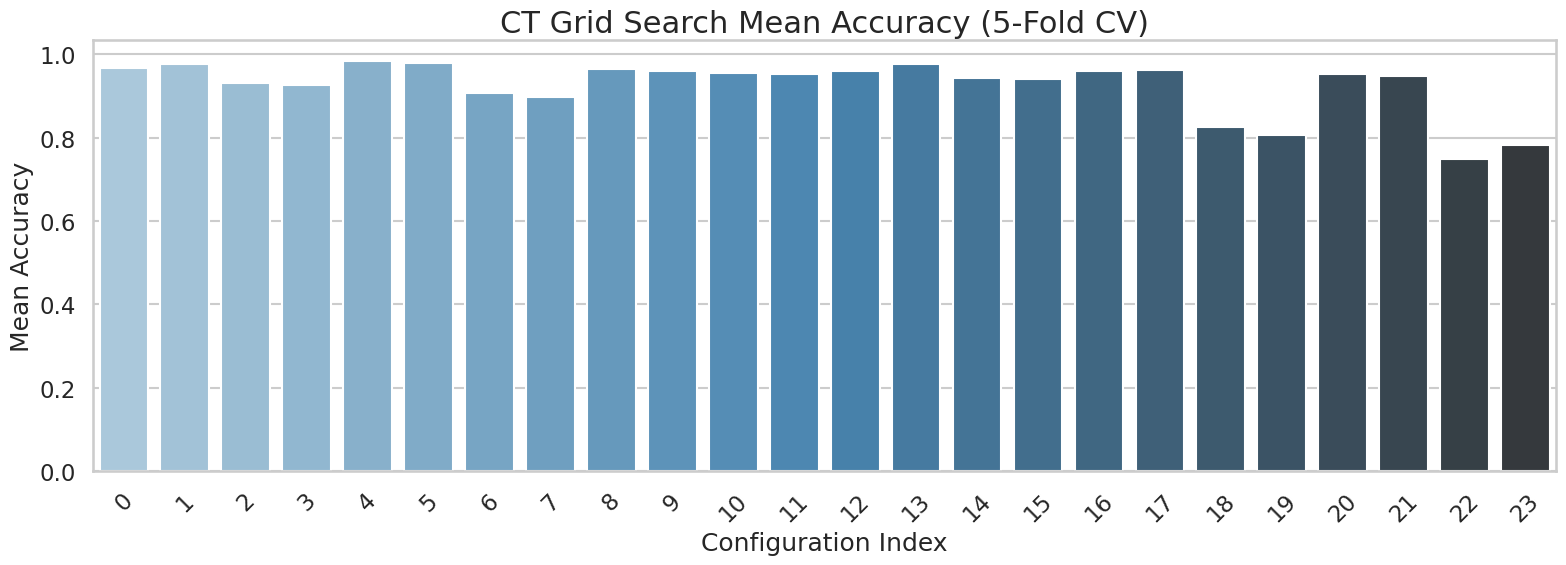

In [ ]:
plt.figure(figsize=(16,6))
sns.barplot(
    x=df_results.index,
    y=df_results["mean_accuracy"],
    palette="Blues_d"
)

plt.title("CT Grid Search Mean Accuracy (5-Fold CV)", fontsize=22)
plt.ylabel("Mean Accuracy", fontsize=18)
plt.xlabel("Configuration Index", fontsize=18)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

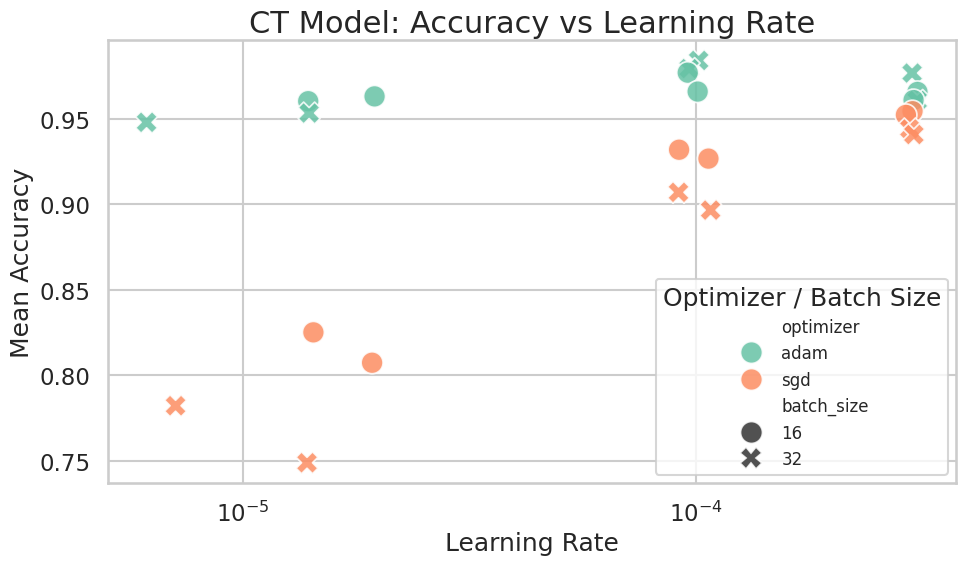

In [ ]:
plt.figure(figsize=(10,6))

# jitter to prevent overlapping dots
def jitter(values, amount=0.00001):
    return values + np.random.uniform(-amount, amount, len(values))

sns.scatterplot(
    x=jitter(df_results["lr"]),
    y=df_results["mean_accuracy"],
    hue=df_results["optimizer"],
    style=df_results["batch_size"],
    s=250,
    palette="Set2",
    alpha=0.85
)

plt.xscale("log")
plt.xlabel("Learning Rate", fontsize=18)
plt.ylabel("Mean Accuracy", fontsize=18)
plt.title("CT Model: Accuracy vs Learning Rate", fontsize=22)

plt.legend(title="Optimizer / Batch Size", fontsize=12)
plt.tight_layout()
plt.show()


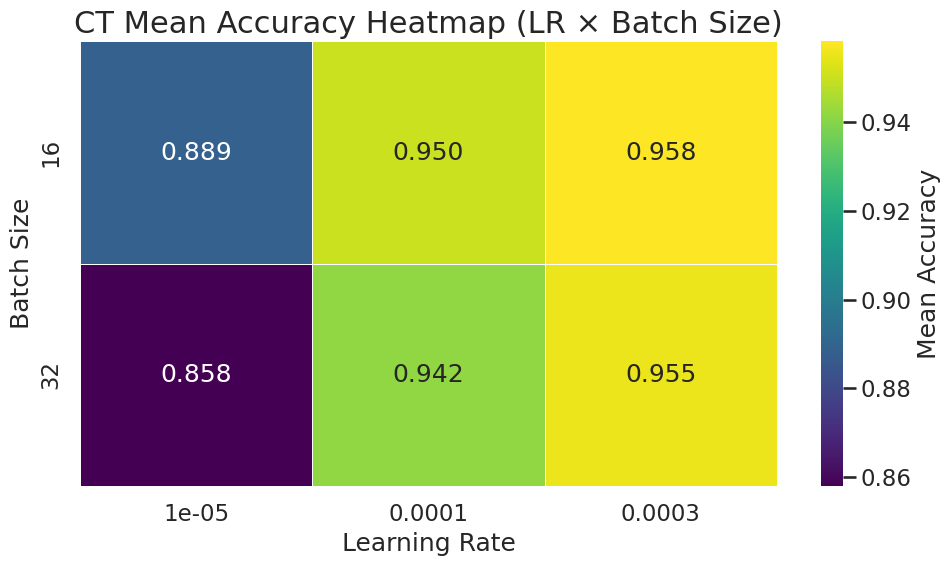

In [ ]:
heatmap_df = df_results.pivot_table(
    index="batch_size",
    columns="lr",
    values="mean_accuracy"
).sort_index()

plt.figure(figsize=(10,6))

sns.heatmap(
    heatmap_df,
    annot=True,
    cmap="viridis",
    fmt=".3f",
    linewidths=.5,
    cbar_kws={"label": "Mean Accuracy"}
)

plt.title("CT Mean Accuracy Heatmap (LR × Batch Size)", fontsize=22)
plt.xlabel("Learning Rate", fontsize=18)
plt.ylabel("Batch Size", fontsize=18)

plt.tight_layout()
plt.show()


/tmp/ipython-input-3692366282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


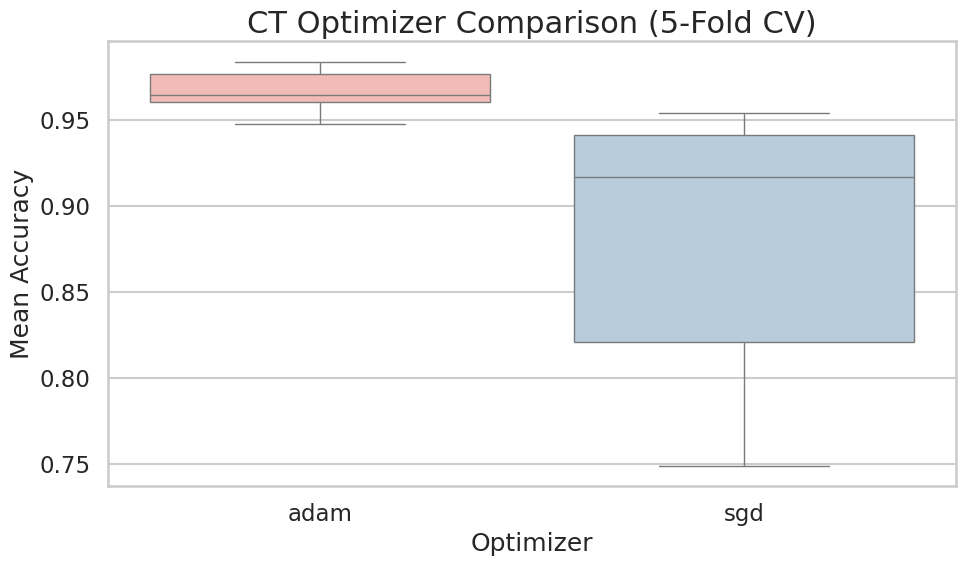

In [ ]:
plt.figure(figsize=(10,6))

sns.boxplot(
    data=df_results,
    x="optimizer",
    y="mean_accuracy",
    palette="Pastel1"
)

plt.title("CT Optimizer Comparison (5-Fold CV)", fontsize=22)
plt.xlabel("Optimizer", fontsize=18)
plt.ylabel("Mean Accuracy", fontsize=18)

plt.tight_layout()
plt.show()

In [ ]:
best = df_results.iloc[0]
best

,4
lr,0.0001
batch_size,32
optimizer,adam
weight_decay,0.0
mean_accuracy,0.983977
mean_f1,0.983886
fold_accs,"[0.9751082251082251, 0.9902597402597403, 0.981..."
fold_f1s,"[0.9746974697469747, 0.9903121636167922, 0.981..."


In [ ]:
skf_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
train_idx, test_idx = next(skf_final.split(np.zeros(len(cached_ct_labels)), cached_ct_labels))

train_dataset = CachedCTDataset(train_idx, train=True)
test_dataset  = CachedCTDataset(test_idx, train=False)

train_loader = DataLoader(train_dataset, batch_size=int(best["batch_size"]), shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=int(best["batch_size"]), shuffle=False, num_workers=2)

In [ ]:
model = build_model()
optimizer = make_optimizer(model, best["optimizer"], best["lr"], best["weight_decay"])

for epoch in range(10):
    loss, acc = train_one_epoch(model, optimizer, train_loader)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}")

torch.save(model.state_dict(), "best_ct_model.pth")

Epoch 1: Loss=0.1490, Acc=0.9380
Epoch 2: Loss=0.0496, Acc=0.9802
Epoch 3: Loss=0.0375, Acc=0.9857
Epoch 4: Loss=0.0315, Acc=0.9884
Epoch 5: Loss=0.0168, Acc=0.9949
Epoch 6: Loss=0.0197, Acc=0.9943
Epoch 7: Loss=0.0133, Acc=0.9962
Epoch 8: Loss=0.0043, Acc=0.9997
Epoch 9: Loss=0.0055, Acc=0.9978
Epoch 10: Loss=0.0114, Acc=0.9968


In [ ]:
test_acc, preds_all, labels_all = eval_epoch(model, test_loader)
print("Final Test Accuracy:", test_acc)

Final Test Accuracy: 0.9935064935064936



Classification Report:

              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       460
       Tumor       0.99      0.99      0.99       464

    accuracy                           0.99       924
   macro avg       0.99      0.99      0.99       924
weighted avg       0.99      0.99      0.99       924



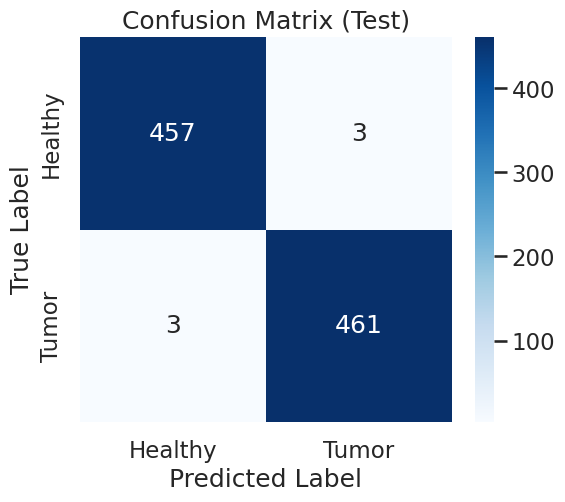

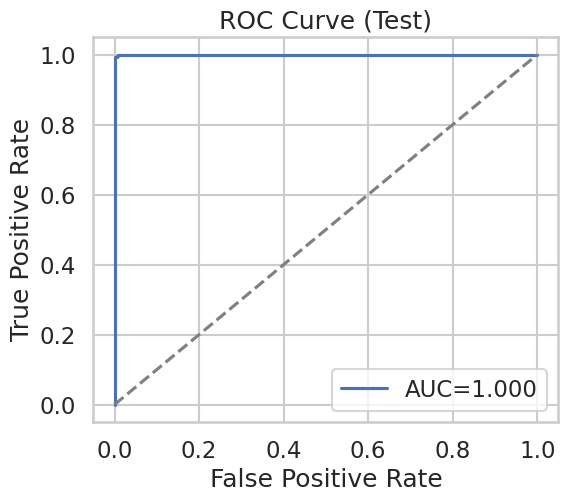

In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(labels_all, preds_all, target_names=["Healthy","Tumor"]))

# Confusion matrix
cm = confusion_matrix(labels_all, preds_all)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy','Tumor'],
            yticklabels=['Healthy','Tumor'])
plt.title("Confusion Matrix (Test)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC + AUC
all_probs = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        with torch.amp.autocast("cuda"):
            logits = model(imgs)
            probs = logits.softmax(dim=1)[:,1]
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(labels_all, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()